**Installing latest pickle to unserialize our data from database**

In [1]:
!pip install pickle5

     |████████████████████████████████| 133kB 19.8MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218630 sha256=6073d309016979ef3a6ec6591f27e578c04f7e9e28ebc0ba534eb7efdb39a570
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


Connecting to drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Adding needed imports**

In [3]:
import os
import  pickle5 as pickle
from HandReading import HandReading
from Imu import Imu
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM
from sklearn.metrics import accuracy_score as acc
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

**Creating dictionary mappers**


In [4]:
dict_word_id = {}
dict_id_word = {}

list_word = os.listdir('/content/drive/MyDrive/database') 
for j in range(len(list_word)) : 
  dict_word_id[list_word[j]] = j
  dict_id_word[j] = list_word[j]
print(dict_word_id)
print(dict_id_word)

{'23': 0, 'lucas': 1, 'oi': 2, 'silencio': 3, 'tchau': 4, 'tudo-bem': 5, 'qual-a-sua-idade': 6, 'prazer-em-te-conhecer': 7, 'meu-nome-e': 8, 'abdullah': 9, 'qual-seu-nome': 10, '.ipynb_checkpoints': 11}
{0: '23', 1: 'lucas', 2: 'oi', 3: 'silencio', 4: 'tchau', 5: 'tudo-bem', 6: 'qual-a-sua-idade', 7: 'prazer-em-te-conhecer', 8: 'meu-nome-e', 9: 'abdullah', 10: 'qual-seu-nome', 11: '.ipynb_checkpoints'}


**Preparing input and labels data**

In [5]:
input_data, output = [], []

list_word = os.listdir('/content/drive/MyDrive/database') 

for word in list_word:
  list_pickle_file = os.listdir(f'/content/drive/MyDrive/database/{word}')
  k = 0 
  for pickle_file in list_pickle_file:
    k+=1
    with open(f'/content/drive/MyDrive/database/{word}/{pickle_file}', 'rb') as input:
      readings = pickle.load(input)
      for reading in readings:
        finger = []
        for i in range(5):
          finger.append(np.float16(reading.imus[i].accel[0]/255.0))
          finger.append(np.float16(reading.imus[i].accel[1]/255.0))
          finger.append(np.float16(reading.imus[i].accel[2]/255.0))
          finger.append(np.float16(reading.imus[i].gyro[0]/255.0))
          finger.append(np.float16(reading.imus[i].gyro[1]/255.0))
          finger.append(np.float16(reading.imus[i].gyro[2]/255.0))
          pass
      
        input_data.append(finger)
        
        out = np.zeros(11)
        out[dict_word_id[word]] = 1.0
        output.append(out)

input_data = np.array(input_data)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
output = np.array(output)

**Creating neural network model**

In [6]:
model = Sequential()
model.add(LSTM(units=50, input_shape=input_data[0].shape))
model.add(Dense(11, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 11)                561       
Total params: 10,961
Trainable params: 10,961
Non-trainable params: 0
_________________________________________________________________


**Separate data and train**

In [7]:
from sklearn.model_selection import StratifiedKFold
kfoldK = 10
kfold = StratifiedKFold(n_splits=10, shuffle=True)
callback = EarlyStopping(monitor='val_accuracy', min_delta = 0.001, patience=3)
iterations = 0 
sumOfAccuracy = 0
maxepoch = 100
for train, test in kfold.split(input_data, output.argmax(1)):
  iterations += 1
  trainX, testX = input_data[train], input_data[test]
  trainY, testY = output[train], output[test]

  trainX, validX, trainY, validY = train_test_split(
    trainX, trainY, test_size=0.3, stratify=trainY, random_state=42)
  
  model.fit(trainX, trainY, epochs=maxepoch, batch_size=32, verbose=2, callbacks=[callback], validation_data=(validX, validY))
  predicted = model.predict(testX)
  pred = []
  for j in predicted:
    arg = np.argmax(j)
    pred.append(arg)
  pred = np.array(pred)
  y_one = []
  for y in testY :
    arg = np.argmax(y)
    y_one.append(arg)
  y_one = np.array(y_one)
  sumOfAccuracy += acc(y_one,pred)
  avgAccuray = sumOfAccuracy/iterations
  print(f"average accuracy = {avgAccuray}")



Epoch 1/100
4119/4119 - 18s - loss: 2.1864 - accuracy: 0.1982 - val_loss: 2.0634 - val_accuracy: 0.2273
Epoch 2/100
4119/4119 - 19s - loss: 1.9799 - accuracy: 0.2607 - val_loss: 1.9223 - val_accuracy: 0.2842
Epoch 3/100
4119/4119 - 18s - loss: 1.8795 - accuracy: 0.2989 - val_loss: 1.8460 - val_accuracy: 0.3074
Epoch 4/100
4119/4119 - 18s - loss: 1.8102 - accuracy: 0.3255 - val_loss: 1.7849 - val_accuracy: 0.3331
Epoch 5/100
4119/4119 - 18s - loss: 1.7551 - accuracy: 0.3466 - val_loss: 1.7355 - val_accuracy: 0.3513
Epoch 6/100
4119/4119 - 18s - loss: 1.7087 - accuracy: 0.3633 - val_loss: 1.6931 - val_accuracy: 0.3669
Epoch 7/100
4119/4119 - 18s - loss: 1.6711 - accuracy: 0.3768 - val_loss: 1.7100 - val_accuracy: 0.3607
Epoch 8/100
4119/4119 - 18s - loss: 1.6389 - accuracy: 0.3875 - val_loss: 1.6429 - val_accuracy: 0.3872
Epoch 9/100
4119/4119 - 18s - loss: 1.6167 - accuracy: 0.3954 - val_loss: 1.6079 - val_accuracy: 0.3980
Epoch 10/100
4119/4119 - 17s - loss: 1.5950 - accuracy: 0.4025 -

**Analyse accuracies**


In [8]:
prd = model.predict(testX)
pred = []
for j in range(len(prd)):
  lis = prd[j]
  arg = np.argmax(lis)
  pred.append(arg)
pred = np.array(pred)

y_one = []
for y in testY :
  arg = np.argmax(y)
  y_one.append(arg)
y_one = np.array(y_one)

print(classification_report(y_one, pred))
print(dict_id_word)
print()
print(acc(y_one,pred))

              precision    recall  f1-score   support

           0       0.86      0.47      0.61      1902
           1       0.44      0.51      0.47      1902
           2       0.35      0.42      0.38      1902
           3       0.99      0.99      0.99      1902
           4       0.72      0.55      0.63      1902
           5       0.34      0.38      0.36      1902
           6       0.27      0.45      0.33      1902
           7       0.19      0.21      0.20      1902
           8       0.70      0.42      0.52      1902
           9       0.54      0.49      0.52      1902
          10       0.40      0.39      0.40      1902

    accuracy                           0.48     20922
   macro avg       0.53      0.48      0.49     20922
weighted avg       0.53      0.48      0.49     20922

{0: '23', 1: 'lucas', 2: 'oi', 3: 'silencio', 4: 'tchau', 5: 'tudo-bem', 6: 'qual-a-sua-idade', 7: 'prazer-em-te-conhecer', 8: 'meu-nome-e', 9: 'abdullah', 10: 'qual-seu-nome', 11: '.ipyn

**Real life usage example**

In [9]:
with open(f'/content/drive/MyDrive/database/tchau/11.pkl', 'rb') as input:
  readings = pickle.load(input)
  input_test_data = []
  j = 0
  for reading in readings:
    finger = []
    for i in range(5):
      finger.append(np.float16(reading.imus[i].accel[0]/255.0))
      finger.append(np.float16(reading.imus[i].accel[1]/255.0))
      finger.append(np.float16(reading.imus[i].accel[2]/255.0))
      finger.append(np.float16(reading.imus[i].gyro[0]/255.0))
      finger.append(np.float16(reading.imus[i].gyro[1]/255.0))
      finger.append(np.float16(reading.imus[i].gyro[2]/255.0))
    
  
    input_test_data.append(finger)
    
input_test_data = np.array(input_test_data)
input_test_data = input_test_data.reshape((input_test_data.shape[0], input_test_data.shape[1], 1))

for inputData in input_test_data:
  result1 = model.predict(inputData.reshape(1,30,1))
  print(dict_id_word[np.argmax(result1)])

qual-a-sua-idade
qual-a-sua-idade
abdullah
oi
qual-seu-nome
qual-a-sua-idade
qual-a-sua-idade
oi
qual-seu-nome
oi
tudo-bem
lucas
oi
tudo-bem
abdullah
qual-a-sua-idade
qual-a-sua-idade
lucas
lucas
tudo-bem
qual-a-sua-idade
tudo-bem
meu-nome-e
qual-a-sua-idade
qual-seu-nome
tudo-bem
oi
tudo-bem
tudo-bem
qual-a-sua-idade
lucas
oi
lucas
lucas
prazer-em-te-conhecer
oi
oi
oi
oi
oi
lucas
meu-nome-e
meu-nome-e
oi
oi
oi
oi
tudo-bem
qual-a-sua-idade
lucas
oi
oi
oi
tudo-bem
tudo-bem
tudo-bem
oi
oi
lucas
lucas
lucas
qual-seu-nome
qual-seu-nome
prazer-em-te-conhecer
prazer-em-te-conhecer
prazer-em-te-conhecer
qual-a-sua-idade
qual-a-sua-idade
qual-a-sua-idade
oi
tudo-bem
tudo-bem
abdullah
qual-seu-nome
lucas
lucas
qual-a-sua-idade
qual-a-sua-idade
tudo-bem
abdullah
abdullah
meu-nome-e
lucas
oi
qual-a-sua-idade
qual-a-sua-idade
lucas
abdullah
abdullah
oi
qual-a-sua-idade
lucas
lucas
oi
qual-seu-nome
qual-seu-nome
lucas
qual-seu-nome
lucas
qual-a-sua-idade
qual-seu-nome
tudo-bem
qual-seu-nome
tchau
l

**Plot model structure**

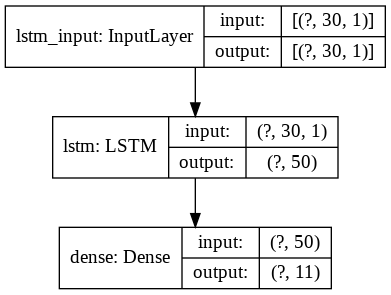

In [10]:
plot_model(model, to_file='topology.png',show_shapes=True)

In [11]:
model.save(f"simple-lstm-{maxepoch}maxepoch-k{kfoldK}fold-{avgAccuray}avgacc.h5", save_format='.h5')
model.save(f"simple-lstm-{maxepoch}maxepoch-k{kfoldK}fold-{avgAccuray}avgacc")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: simple-lstm-100maxepoch-k10fold-0.4638849058407418avgacc/assets
